#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
#from utils.dice_score import multiclass_dice_coeff, dice_coeff

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])

# Erstellen Sie eine Instanz des Trainingssplits des FashionMNIST-Datasets
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Jetzt erstellen Sie eine Instanz des Testsplits
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Für unsere Zwecke können wir die 60k Training- und 10k Testbeispiele kombinieren
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset_train, dataset_valid])

# Einige Informationen zum Datensatz anzeigen
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2048,
                                          shuffle=True, num_workers=2)

print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


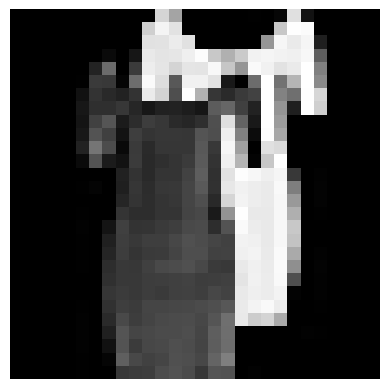

The image shows an instance of Dress.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.cpu().squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
min_value = torch.min(img_tensor)
max_value = torch.max(img_tensor)

print(f"Minimaler Wert: {min_value.item()}")
print(f"Maximaler Wert: {max_value.item()}")



Minimaler Wert: -1.0
Maximaler Wert: 1.0


In [5]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [6]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule



In [7]:
def normalize_image(image):
    min_value = torch.min(image)
    max_value = torch.max(image)
    
    normalized_image = 2 * ((image - min_value) / (max_value - min_value)) - 1
    return normalized_image

In [8]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    noise = torch.empty_like(image).normal_(mean=0,std=1) * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise

In [9]:
def one_forward_step(curr_image, beta):
    std = np.sqrt(beta) #* np.random.normal()#* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(1-beta) * curr_image #+ std
    return add_gaussian_noise(curr_image,mean=mean,std=std)

In [10]:
def mache_noise(image, anzahl_bilder):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    verrauschte_bilder = []
    schedule = create_linear_schedule(anzahl_bilder, 0.0001, 0.02)
    print(schedule)
    noisy_image_tensor = image
    for i in range(len(schedule)):
        noisy_image_tensor = one_forward_step(noisy_image_tensor, schedule[i])
        
        # Convert the noisy image tensor back to a PIL image
        noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
        
        verrauschte_bilder.append(noisy_image)
        
        # Optional: Display each noisy image if desired
        plt.imshow(noisy_image, cmap='Greys_r')
        plt.title(f"Noisy Image {i+1}: {noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
        plt.show()
    

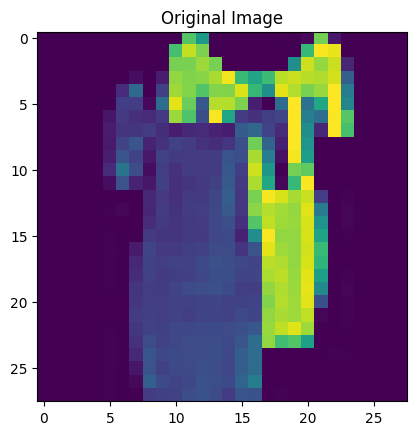

[0.0001, 0.0050750000000000005, 0.01005, 0.015025, 0.02]


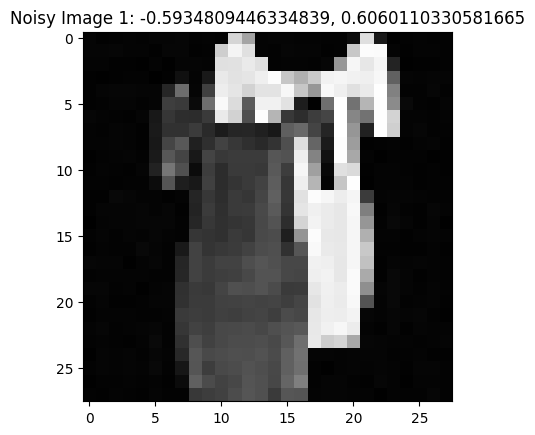

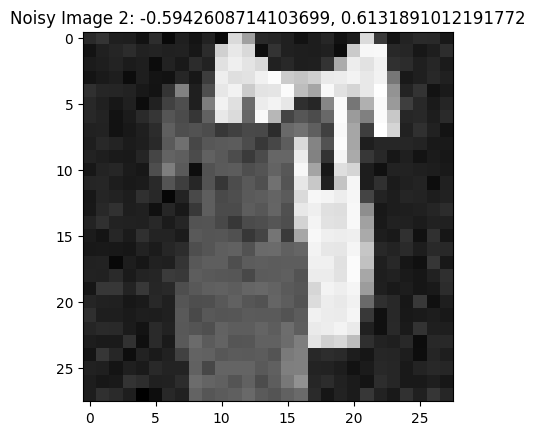

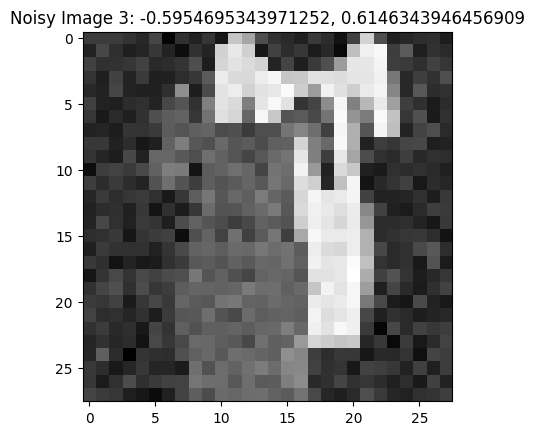

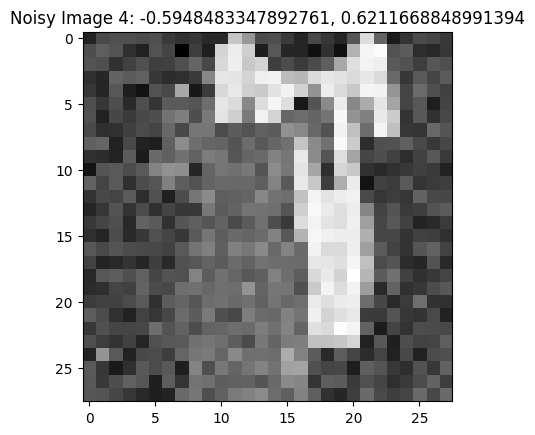

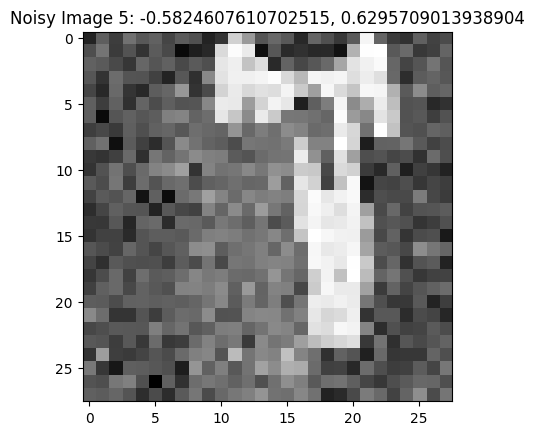

In [11]:
img_tensor = img_tensor.to(device)
mache_noise(img_tensor, 5)

In [12]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [13]:
def x_forward_steps(curr_image, alpha_quer):
    std = np.sqrt(1 - alpha_quer) #* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(alpha_quer) * curr_image
    return add_gaussian_noise(curr_image,mean=mean,std=std)

In [14]:
def mache_noise_direkt(image, anzahl_steps, total_steps):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    plt.imshow(noisy_image, cmap="Greys_r")
    plt.title(f"Noisy Image :{noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
    plt.show()
    


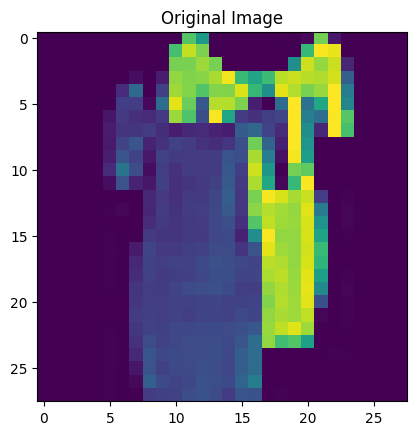

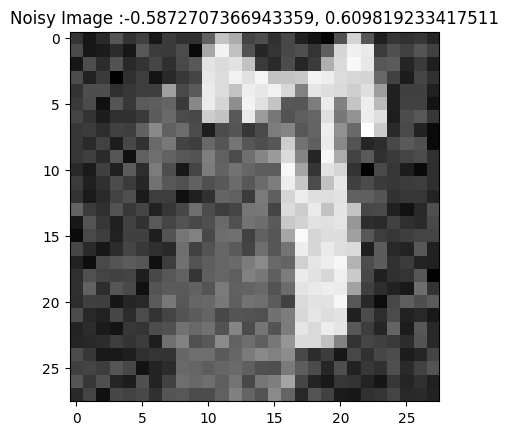

In [15]:

mache_noise_direkt(img_tensor, 4, 5)

In [16]:
# U-net architecture: Eingabe (Bild) -> Ausgabe (Segmentation map)

In [17]:
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [18]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [19]:
# Comments inspired from https://distill.pub/2016/deconv-checkerboard/

#Stride 1 deconvolutions — which we often see as the last layer in successful models 
#(eg. [2])  — are quite effective at dampening artifacts. 
#In particular, deconvolution has uneven overlap when the kernel size 
#(the output window size) is not divisible by the stride (the spacing between points on the top).

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        #Another approach is to separate out upsampling to a higher resolution from convolution to compute features.
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        #Diese Zeilen berechnen die Größenunterschiede
        #in den Höhen- und Breitenrichtungen zwischen x2 und dem upgesampleten x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        #Diese Zeile fügt x1 an den Rändern Polster hinzu, 
        #sodass es die gleiche räumliche Größe wie x2 hat. Das 
        #Padding sorgt dafür, dass die beiden Feature-Maps aneinander angehängt werden können.

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [20]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [21]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [22]:
def concat_pos_param(x, enc):
    pos_enc_reshape = enc.reshape(1,-1,1,1).expand((x.shape[0],-1,x.shape[2],x.shape[3]))
    feature_map_with_encoding = torch.cat([x, pos_enc_reshape], dim=1)
    return feature_map_with_encoding

In [23]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, t_max=1000, d_hid=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        factor = 2
        self.pos_enc = get_sinusoid_encoding_table(t_max, d_hid)#nn.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        self.pos_enc.requires_grad = False 
        self.inc = (DoubleConv(n_channels + d_hid, 64))
        self.down1 = (Down(64 + d_hid, 128))
        self.down2 = (Down(128 + d_hid, 256 // factor))
        #self.down3 = (Down(256, 512))
        #self.down4 = (Down(512, 1024 // factor))
        #self.up1 = (Up(1024, 512 // factor))
        #self.up2 = (Up(512, 256 // factor))
        self.up3 = (Up(256, 128 // factor))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_channels))

    def forward(self, x, t):
        enc = self.pos_enc[t]
        
        
        x1 = self.inc(concat_pos_param(x, enc))
        x2 = self.down1(concat_pos_param(x1, enc))
        x3 = self.down2(concat_pos_param(x2, enc))
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        #x = self.up2(x, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [24]:
unet = UNet(1,100)
dataiter = iter(trainloader)
i, data = next(dataiter)


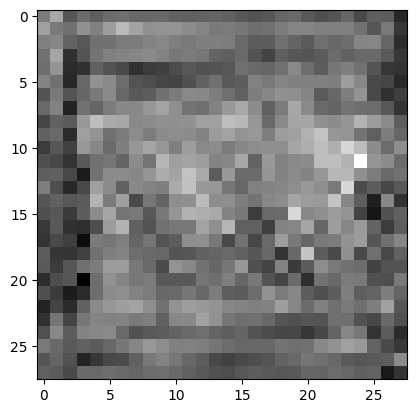

In [25]:
for j in range(1):
    img = unet(i, 5).detach().numpy()[0, j, :, :]
    plt.imshow(img, cmap='gray')  # `cmap='gray'` wird verwendet, da es sich um ein Graustufenbild handelt
    plt.show()

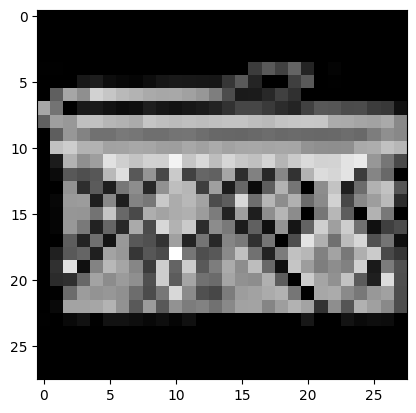

In [33]:
plt.imshow(i[0, 0, :, :], cmap='gray')
plt.show()


In [27]:
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)

In [28]:
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)
